In [2]:
import numpy as np
import matplotlib.pyplot as plt
import sys, os, cv2, struct

caffe_root = '/home/heyanguang/caffecode/caffe/'
sys.path.insert(0, caffe_root + 'python')
os.chdir(caffe_root)
import caffe

caffe.set_mode_gpu()
net = caffe.Net(caffe_root + 'examples/cifar10/cifar10_quick.prototxt',
                caffe_root + 'examples/cifar10/cifar10_quick_iter_10000.caffemodel.h5',
                caffe.TEST)
print "net.blobs['data'].data.dtype: ", net.blobs['data'].data.dtype
print "net.blobs['conv1'].data.dtype: ", net.blobs['conv1'].data.dtype
print "net.params['conv1'][0].data.dtype: ", net.params['conv1'][0].data.dtype

def get_image_label(filename, read_count, start_location):
    f1 = open(filename, 'rb')
    buf1 = f1.read()
    
    image = np.zeros((read_count, 32, 32, 3)).astype('uint8')
    label = np.zeros(read_count).astype('uint8')
    image_offset = 3073 * start_location
    for i in range(read_count):
        im_la = []
        temp = struct.unpack_from('B', buf1, image_offset)
        label[i] = np.array(temp)
        image_offset += 1
        temp = struct.unpack_from('3072B', buf1, image_offset)
        image[i] = np.reshape(temp, (3, 32, 32)).transpose(1, 2, 0).astype('uint8')
        image_offset += 3072
    return image, label

def convert_mean(binMean, npyMean):
    blob = caffe.proto.caffe_pb2.BlobProto()
    bin_mean = open(binMean, 'rb').read()
    blob.ParseFromString(bin_mean)
    arr = np.array(caffe.io.blobproto_to_array(blob))
    npy_mean = arr[0]
    np.save(npyMean, npy_mean)
    
binMean = caffe_root + 'examples/cifar10/mean.binaryproto'
npyMean = caffe_root + 'examples/cifar10/mean.npy'
convert_mean(binMean, npyMean)

read_count = 40
start_location = 234
image_label = get_image_label('data/cifar10/test_batch.bin', read_count, start_location)
# label_name = open('data/cifar10/batches.meta.txt').readline()
# label_name = open('data/cifar10/batches.meta.txt').readlines()
# label_name = open('data/cifar10/batches.meta.txt').read().replace('\n', ' ').split()
label_name = open('data/cifar10/batches.meta.txt').read().split()
print 'label_name: ', label_name
print 'len(label_name): ', len(label_name)

# plt.imshow(image_label[0][6], cmap = 'gray')
# plt.imshow(image_label[0][8])
# plt.imshow(cv2.cvtColor(image_label[0][8], cv2.COLOR_BGR2RGB))
# for i in range(read_count):
#     plt.imshow(image_label[0][i])
#     plt.show()

print 'type(image_label[0]): ', type(image_label[0])
print 'type(image_label[1]): ', type(image_label[1])
print 'image_label[0].shape: ', image_label[0].shape
print 'image_label[0].dtype: ', image_label[0].dtype


net.blobs['data'].data.dtype:  float32
net.blobs['conv1'].data.dtype:  float32
net.params['conv1'][0].data.dtype:  float32
label_name:  ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
len(label_name):  10
type(image_label[0]):  <type 'numpy.ndarray'>
type(image_label[1]):  <type 'numpy.ndarray'>
image_label[0].shape:  (40, 32, 32, 3)
image_label[0].dtype:  uint8


prediction error count:  10
accuracy 0.75
cat -> dog (ground_true)


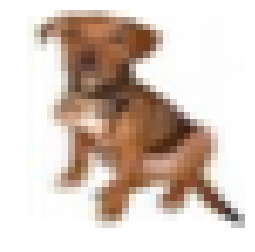

automobile -> ship (ground_true)


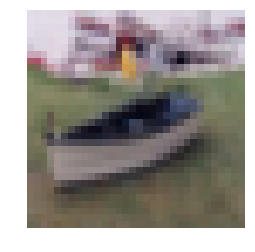

frog -> cat (ground_true)


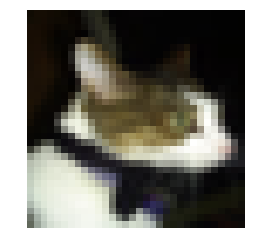

ship -> truck (ground_true)


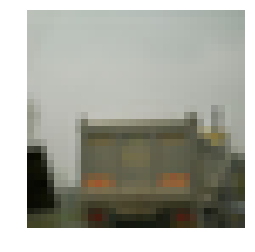

airplane -> bird (ground_true)


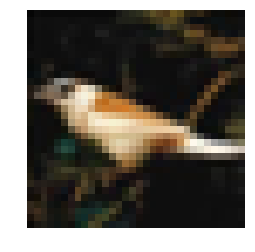

frog -> cat (ground_true)


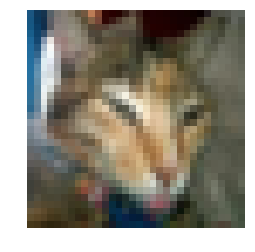

ship -> airplane (ground_true)


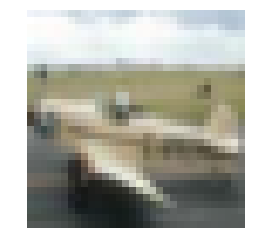

automobile -> truck (ground_true)


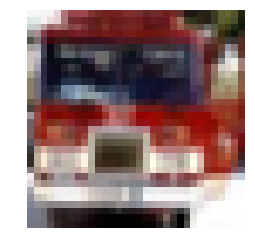

cat -> horse (ground_true)


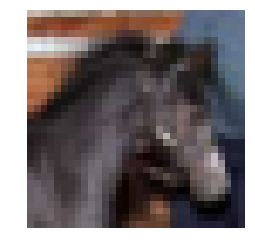

airplane -> bird (ground_true)


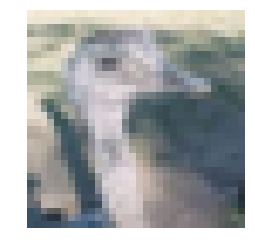

In [7]:
mean = np.load(npyMean)
im_input = image_label[0].transpose(0, 3, 1, 2).astype('float') - mean
net.blobs['data'].reshape(*im_input.shape)
net.blobs['data'].data[:] = im_input
net.forward()

def find_fault_prediction(result, label):
    result_wrong = []
    ground_true = []
    index = []
    i = 0
    it = iter(label)
    for v in result:
        el = next(it)
        if v != el:
            result_wrong.append(v)
            ground_true.append(el)
            index.append(i)
        i += 1
    return result_wrong, ground_true, index

result = net.blobs['prob'].data.argsort()[:, -1]
fault = find_fault_prediction(result, image_label[1])
mismatch = zip(fault[0], fault[1])

# aa = zip([1, 2], (3, 4))
# # aa = [[1, 2], [5, 6, 8], (3, 4)]
# for x, y in aa:
#     print x, '->', y, '(ground_true)'
# print aa

# print 'mismatch: ', mismatch
print 'prediction error count: ', len(mismatch)
accuracy = 1 - len(mismatch)/float(len(image_label[1]))
print 'accuracy', accuracy
if len(mismatch):
    it = iter(fault[2])
    for x, y in mismatch:
        print label_name[x], '->', label_name[y], '(ground_true)'
        plt.imshow(image_label[0][next(it)])
        plt.axis('off')
        plt.show()

# it = iter(range(len(image_label[0])))
# for x, y in zip(result, image_label[1]):
#     print label_name[x], '->', label_name[y], '(ground_true)'
#     plt.imshow(image_label[0][next(it)])
#     plt.axis('off')
#     plt.show()



In [179]:
print 'im_input.dtype', im_input.dtype
print 'mean.dtype', mean.dtype
print mean.shape
print image_label[0].shape
k = 1
a = image_label[0][k] - mean.transpose(1, 2, 0)
b1 = image_label[0] - mean.transpose(1, 2, 0)
b = b1[k]
np.linalg.norm(a - b)

im_input.dtype float64
mean.dtype float64
(3, 32, 32)
(10, 32, 32, 3)


0.0

In [120]:
[(k, v.data.shape) for k, v in net.blobs.items()]

[('data', (10, 3, 32, 32)),
 ('conv1', (10, 32, 32, 32)),
 ('pool1', (10, 32, 16, 16)),
 ('conv2', (10, 32, 16, 16)),
 ('pool2', (10, 32, 8, 8)),
 ('conv3', (10, 64, 8, 8)),
 ('pool3', (10, 64, 4, 4)),
 ('ip1', (10, 64)),
 ('ip2', (10, 10)),
 ('prob', (10, 10))]